# **Project Name**    - Multi Class Fish Image Classification

##### **Project Type**    - Classification
##### **Contribution**    - Individual
##### **Team Member 1 -**  Tanuj Jain

# **Project Summary -**

This project builds a **fish species image classifier** using transfer learning with pre-trained CNN architectures like **VGG16**, **ResNet50**, **MobileNetV2**, **InceptionV3**, and **EfficientNetB0**. Images are preprocessed and augmented via **ImageDataGenerator** to enhance generalization. The `build_transfer_model` function freezes the base model, adds custom layers, and trains on fish dataset classes. Evaluation includes accuracy, loss curves, and classification reports. A **Streamlit** app enables users to upload images, select a model, and view predictions with confidence scores. This modular and interactive setup allows efficient experimentation with different architectures, making it a robust framework for both learning and deployment in real-world classification tasks.


# **GitHub Link -** [Click Here](https://github.com/TANUJ0751/Multiclass-Fish-Image-Classification)

# **Project Link -** [Click Here](https://tanujs-fish-image-classification.streamlit.app)

# **Problem Statement**

## ***1. Know Your Data***

### Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping


2025-08-09 14:10:28.086368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754728828.230821     411 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754728828.272166     411 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754728828.572207     411 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754728828.572280     411 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754728828.572283     411 computation_placer.cc:177] computation placer alr

### Dataset Loading

In [2]:

base_dir = "./data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


## ***Data Visualization***

#### No. of Images in Each Class

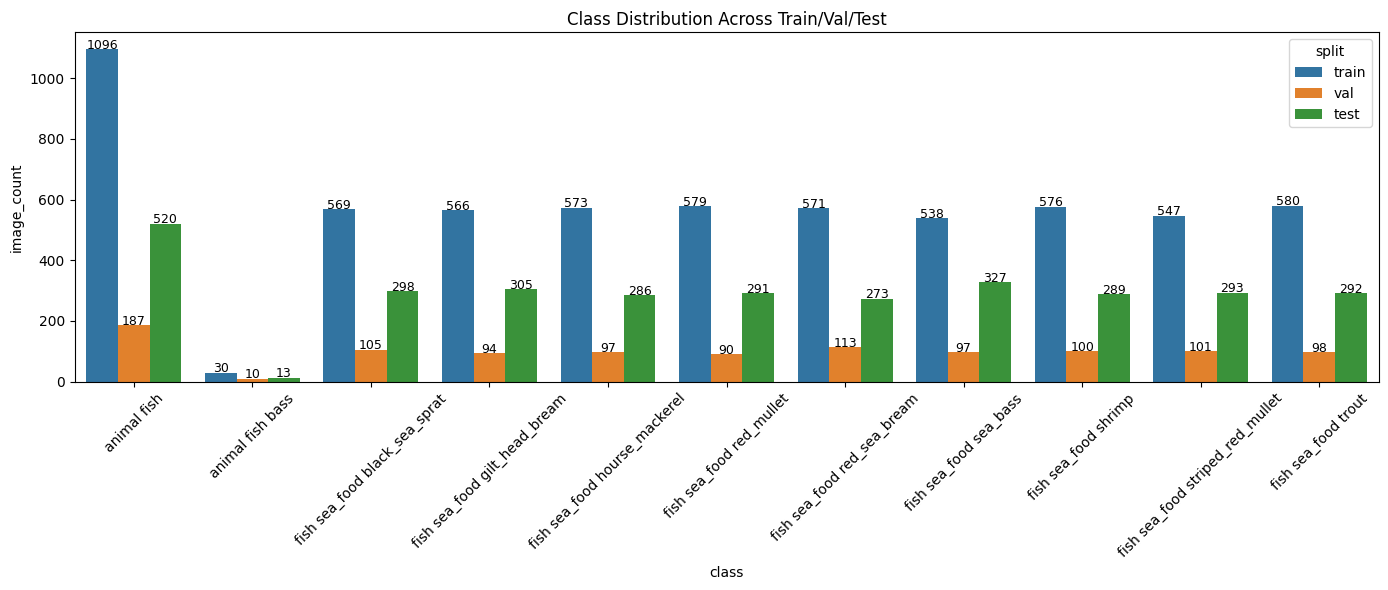

In [3]:
splits = ['train', 'val', 'test']
distribution = []

for split in splits:
    split_path = os.path.join(base_dir, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                f for f in os.listdir(class_path) 
                if f.lower().endswith(('.jpg', '.png', '.jpeg'))
            ])
            distribution.append({
                'split': split,
                'class': class_name,
                'image_count': num_images
            })

df_dist = pd.DataFrame(distribution)

# Plot class distribution
plt.figure(figsize=(14, 6))
ax = sns.barplot(data=df_dist, x='class', y='image_count', hue='split')

plt.title("Class Distribution Across Train/Val/Test")
plt.xticks(rotation=45)
plt.tight_layout()

# Add counts above bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2., height + 1,
                f'{int(height)}', ha="center", fontsize=9)

plt.show()

#### Dataset First View

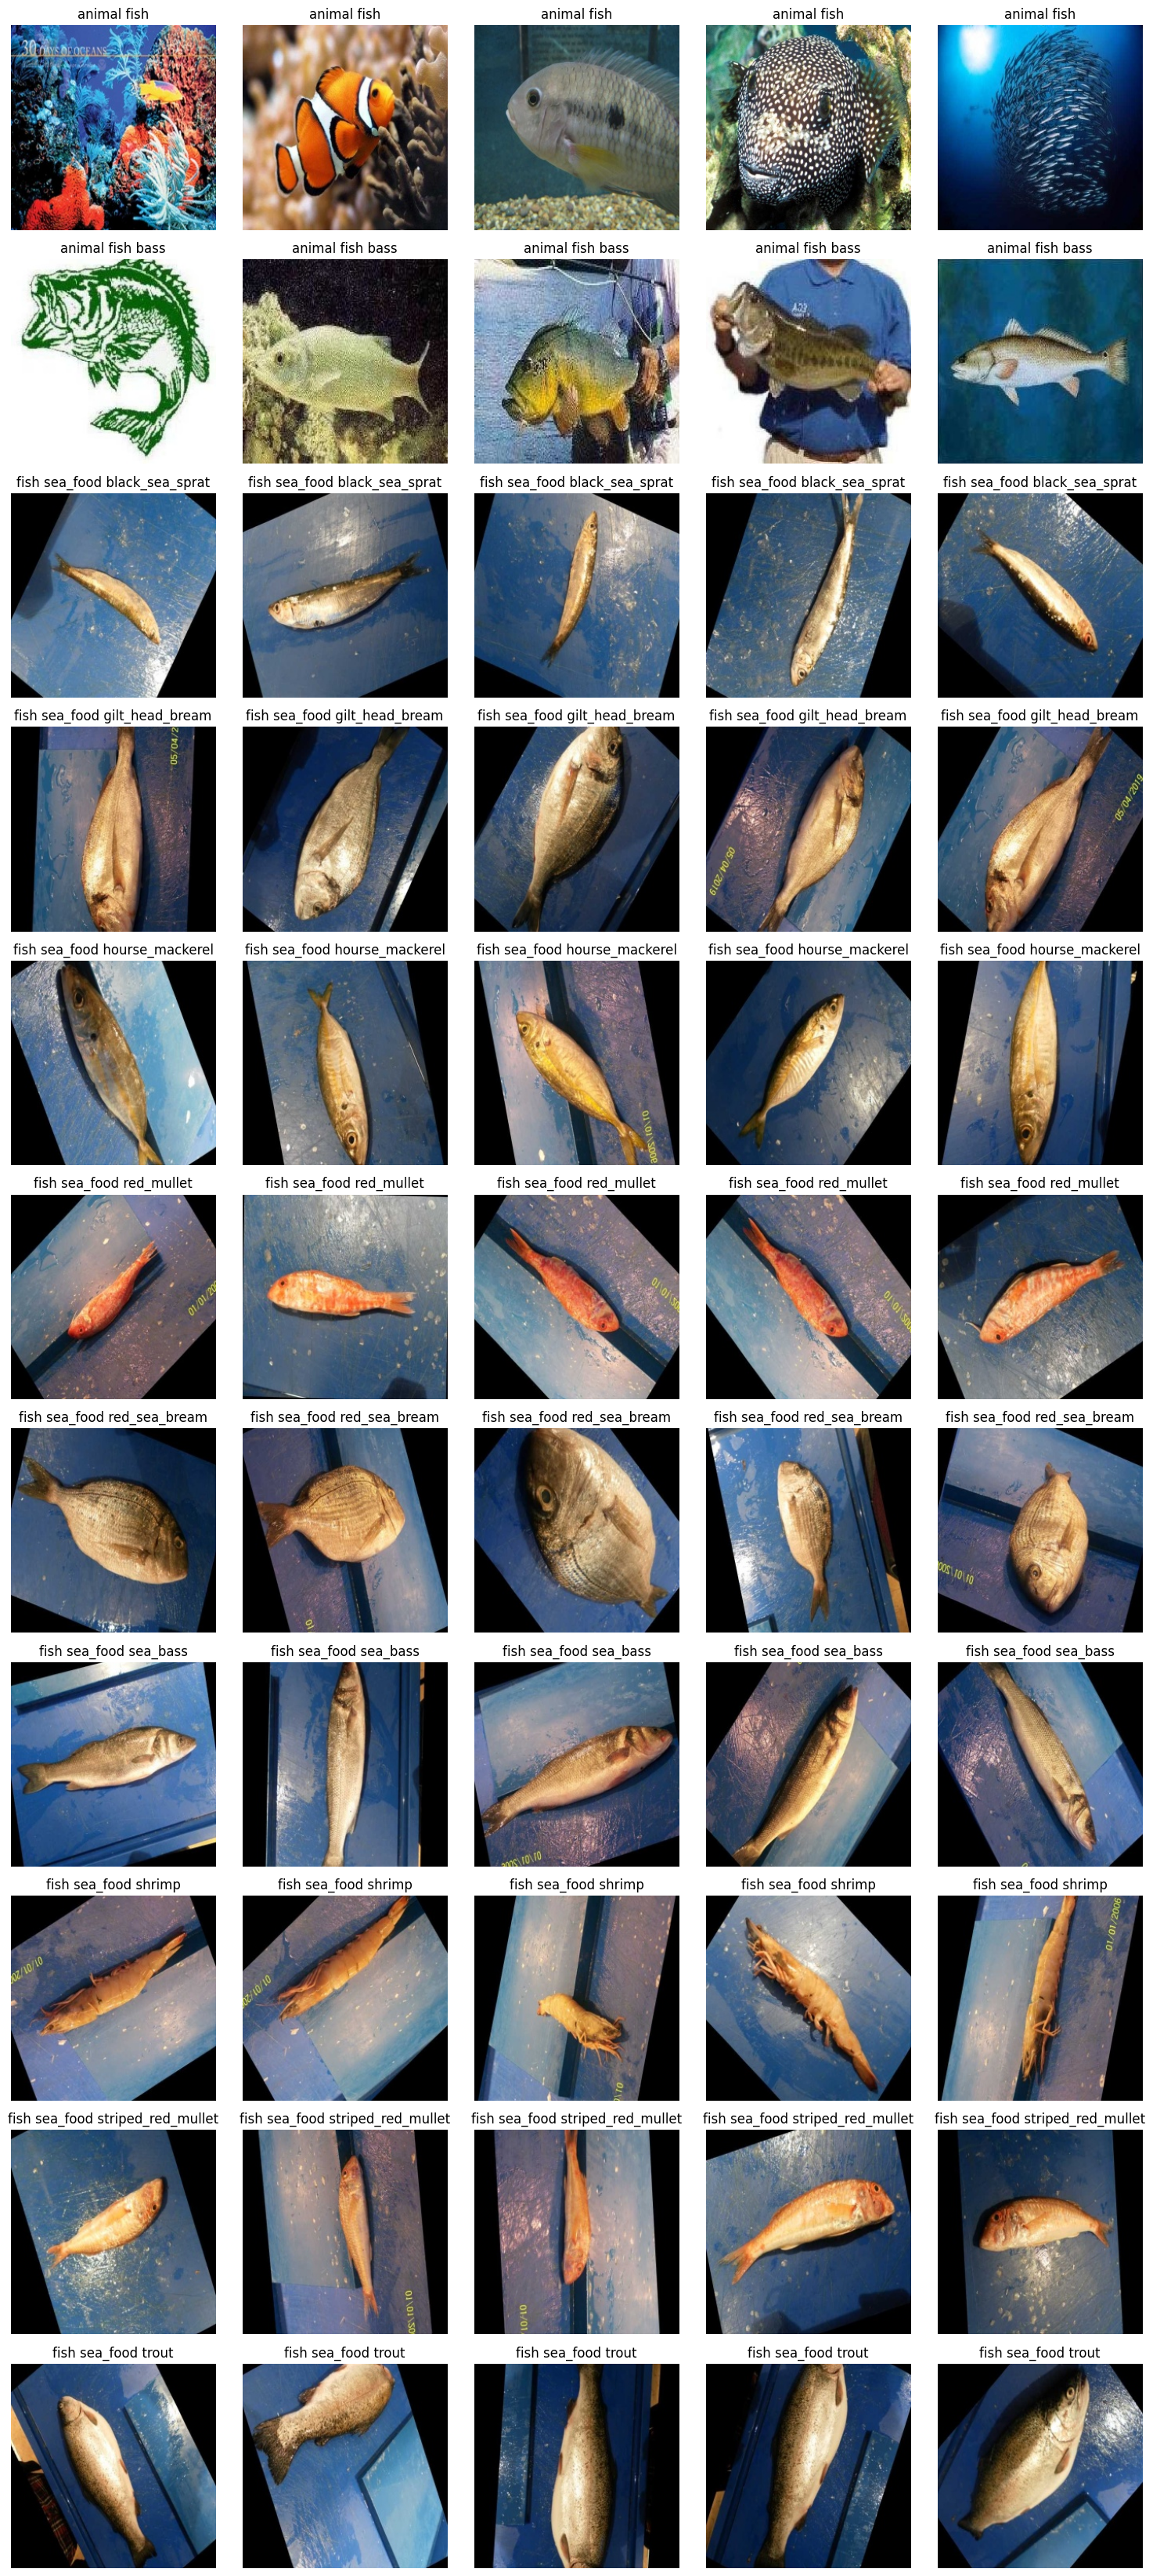

In [4]:
import matplotlib.image as mpimg
import random

def show_sample_images(base_dir, split='train', n=5):
    split_path = os.path.join(base_dir, split)
    class_dirs = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    
    plt.figure(figsize=(15, 3 * len(class_dirs)))
    img_index = 1
    for class_name in sorted(class_dirs):
        class_path = os.path.join(split_path, class_name)
        sample_files = random.sample([
            f for f in os.listdir(class_path) 
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ], min(n, len(os.listdir(class_path))))
        
        for file in sample_files:
            img = mpimg.imread(os.path.join(class_path, file))
            plt.subplot(len(class_dirs), n, img_index)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)
            img_index += 1

    plt.tight_layout()
    plt.show()

# Show 5 images per class from train set
show_sample_images(base_dir, split='train', n=5)


#### Checking Image Size and Width for all Images

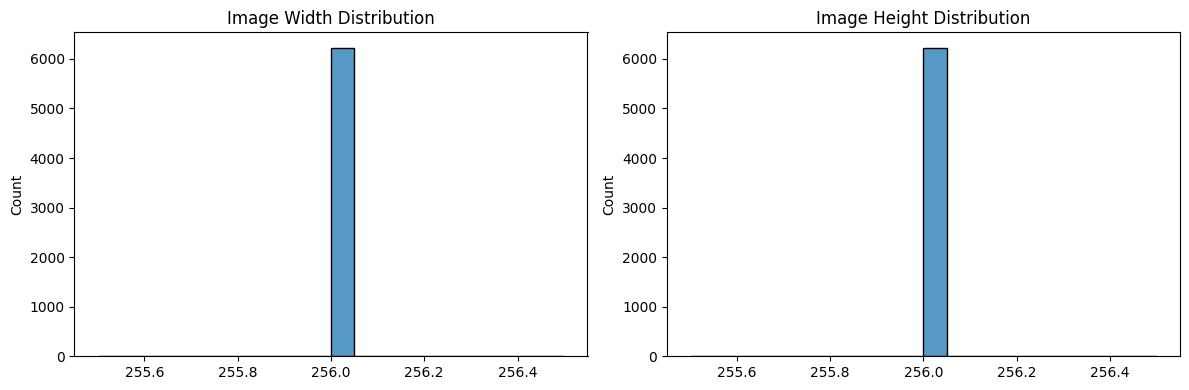

Average Image Size: 256.0 x 256.0


In [5]:
from PIL import Image
import numpy as np

def get_image_shapes(base_dir, split='train'):
    shapes = []
    split_path = os.path.join(base_dir, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        for file in os.listdir(class_path):
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                try:
                    img_path = os.path.join(class_path, file)
                    with Image.open(img_path) as img:
                        shapes.append(img.size)  # (width, height)
                except:
                    continue
    return shapes

# Analyze shapes in train set
shapes = get_image_shapes(base_dir, 'train')
widths, heights = zip(*shapes)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20)
plt.title("Image Width Distribution")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20)
plt.title("Image Height Distribution")

plt.tight_layout()
plt.show()

print(f"Average Image Size: {np.mean(widths):.1f} x {np.mean(heights):.1f}")


## Data Preprocessing

In [13]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_data = test_val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_data = test_val_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

class_names = list(train_data.class_indices.keys())
num_classes = len(class_names)


### Helper Function for Printing Training Phase History

In [7]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.savefig(f"plots/{model_name}_history.png")
    plt.show()


### Helper Function for Creating Custom CNN Model

In [8]:
def build_custom_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model



### Model 1 - Custom CNN Model

#### Creating Custom CNN Model

In [9]:
cnn_model = build_custom_cnn()
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/tanuj/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754728860.485485     411 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


### Defining No of Epochs for all Models

In [10]:
EPOCHS=20

### Training Custom CNN Model

In [11]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history_cnn = cnn_model.fit(train_data, validation_data=val_data, epochs=EPOCHS, callbacks=[early_stop])



#### Saving Custom CNN Model

In [12]:
cnn_model.save("models/custom_cnn_model.h5")
plot_history(history_cnn, "Custom_CNN")


#### Evaluating and Printing Accuracy of the Model

In [13]:
loss, accuracy = cnn_model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {accuracy*100:.2f}%")

#### Helper function for making a Transfer Model

In [14]:
def build_transfer_model(base_model, preprocess_input_fn, name):
    base = base_model(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    base.trainable = False

    model = Sequential([
        tf.keras.layers.Lambda(preprocess_input_fn, input_shape=(*IMG_SIZE, 3)),
        base,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


#### List of Models to Train

In [15]:
models_to_train = {
    "VGG16": (VGG16, vgg_preprocess),
    "ResNet50": (ResNet50, resnet_preprocess),
    "MobileNetV2": (MobileNetV2, mobile_preprocess),
    "InceptionV3": (InceptionV3, inception_preprocess) 
}

#### Training all Transfer Learning Models


Training VGG16...


/home/tanuj/myenv/lib/python3.10/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/tanuj/myenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1754728864.192056     590 service.cc:152] XLA service 0x7f803800f470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754728864.192103     590 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-09 14:11:04.244936: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754728864.676891     590 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-09 14:11:05.547324: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0} %bitcast.3357, f32[64,3,3,3]{3,2,1,0} %bitcast.3364, f32[64]{0} %bitcast.3366), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 411ms/step - accuracy: 0.0660 - loss: 4.3153

2025-08-09 14:11:27.818112: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[17,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[17,3,224,224]{3,2,1,0} %bitcast.3357, f32[64,3,3,3]{3,2,1,0} %bitcast.3364, f32[64]{0} %bitcast.3366), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/tanuj/myenv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-08-09 14:11:28.127876: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.0776 - loss: 3.3857

2025-08-09 14:13:18.781704: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[4,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,224,224]{3,2,1,0} %bitcast.820, f32[64,3,3,3]{3,2,1,0} %bitcast.827, f32[64]{0} %bitcast.829), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/tanuj/myenv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-08-09 14:13:19.320556: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omi

195/195 ━━━━━━━━━━━━━━━━━━━━ 141s 610ms/step - accuracy: 0.1059 - loss: 2.7972 - val_accuracy: 0.1712 - val_loss: 2.3154
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 98s 498ms/step - accuracy: 0.1676 - loss: 2.3236 - val_accuracy: 0.1712 - val_loss: 2.3101
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 98s 498ms/step - accuracy: 0.1727 - loss: 2.3157 - val_accuracy: 0.1712 - val_loss: 2.3103
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 498ms/step - accuracy: 0.1735 - loss: 2.3101 - val_accuracy: 0.1712 - val_loss: 2.3117
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 98s 498ms/step - accuracy: 0.1737 - loss: 2.3068 - val_accuracy: 0.1712 - val_loss: 2.3067
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 493ms/step - accuracy: 0.1748 - loss: 2.3058 - val_accuracy: 0.1712 - val_loss: 2.3080
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 498ms/step - accuracy: 0.1748 - loss: 2.3055 - val_accuracy: 0.1712 - val_loss: 2.3096
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 497ms/step - accuracy: 0.1753 - loss: 2.3023 - va

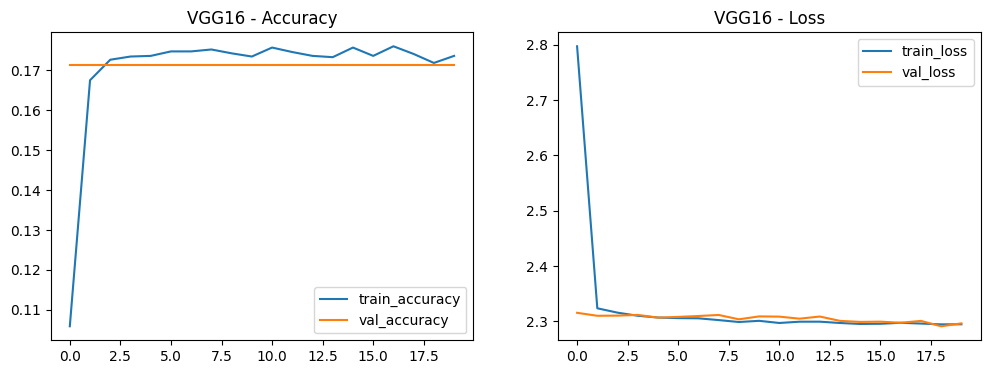


Training ResNet50...
Epoch 1/20


2025-08-09 14:43:24.212175: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.162 = (f32[32,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,56,56]{3,2,1,0} %bitcast.7382, f32[64,64,3,3]{3,2,1,0} %bitcast.7389, f32[64]{0} %bitcast.7391), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/resnet50_1/conv2_block1_2_conv_1/convolution" source_file="/home/tanuj/myenv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-08-09 14:43:24.920601: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

103/195 ━━━━━━━━━━━━━━━━━━━━ 34s 373ms/step - accuracy: 0.1277 - loss: 2.6249

2025-08-09 14:44:10.079692: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.162 = (f32[17,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[17,64,56,56]{3,2,1,0} %bitcast.7382, f32[64,64,3,3]{3,2,1,0} %bitcast.7389, f32[64]{0} %bitcast.7391), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/resnet50_1/conv2_block1_2_conv_1/convolution" source_file="/home/tanuj/myenv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-08-09 14:44:10.648744: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.1335 - loss: 2.5431

2025-08-09 14:44:58.060967: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.162 = (f32[4,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,56,56]{3,2,1,0} %bitcast.4845, f32[64,64,3,3]{3,2,1,0} %bitcast.4852, f32[64]{0} %bitcast.4854), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/resnet50_1/conv2_block1_2_conv_1/convolution" source_file="/home/tanuj/myenv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-08-09 14:44:58.415935: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

195/195 ━━━━━━━━━━━━━━━━━━━━ 105s 475ms/step - accuracy: 0.1438 - loss: 2.4202 - val_accuracy: 0.1722 - val_loss: 2.2537
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 401ms/step - accuracy: 0.1754 - loss: 2.2818 - val_accuracy: 0.1777 - val_loss: 2.2140
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 404ms/step - accuracy: 0.1841 - loss: 2.2428 - val_accuracy: 0.1987 - val_loss: 2.1762
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 404ms/step - accuracy: 0.1945 - loss: 2.2125 - val_accuracy: 0.2134 - val_loss: 2.1668
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 407ms/step - accuracy: 0.1963 - loss: 2.1987 - val_accuracy: 0.2234 - val_loss: 2.1288
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 405ms/step - accuracy: 0.2137 - loss: 2.1814 - val_accuracy: 0.2299 - val_loss: 2.1092
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 399ms/step - accuracy: 0.2130 - loss: 2.1734 - val_accuracy: 0.2390 - val_loss: 2.0834
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 408ms/step - accuracy: 0.2130 - loss: 2.1639 - va

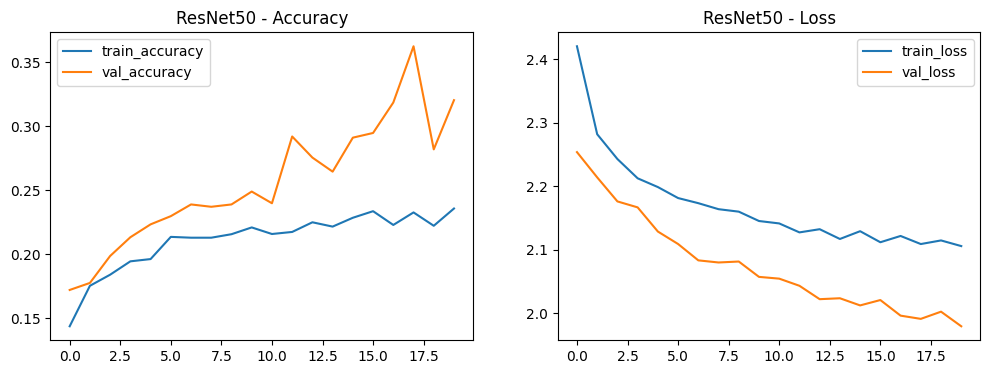


Training MobileNetV2...
Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 101s 466ms/step - accuracy: 0.1165 - loss: 2.5726 - val_accuracy: 0.1712 - val_loss: 2.2947
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 403ms/step - accuracy: 0.1459 - loss: 2.4138 - val_accuracy: 0.1969 - val_loss: 2.2896
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.1573 - loss: 2.3552 - val_accuracy: 0.1841 - val_loss: 2.2979
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 401ms/step - accuracy: 0.1650 - loss: 2.3272 - val_accuracy: 0.1685 - val_loss: 2.2701
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 85s 436ms/step - accuracy: 0.1749 - loss: 2.3130 - val_accuracy: 0.1777 - val_loss: 2.2430


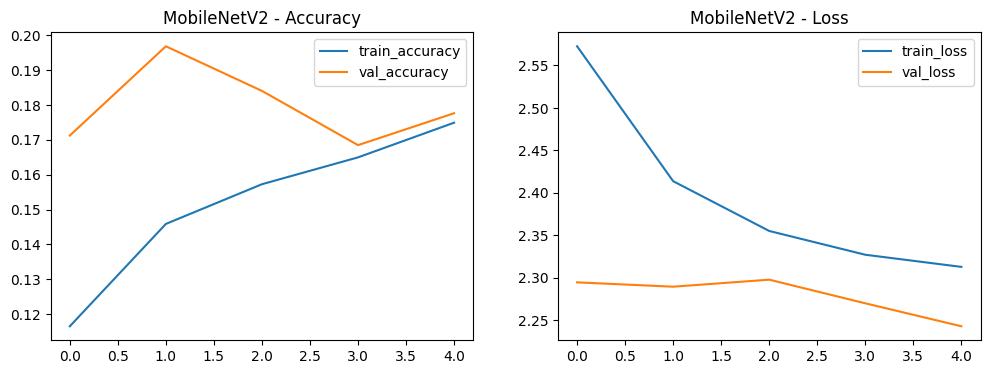


Training InceptionV3...
Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 123s 530ms/step - accuracy: 0.1998 - loss: 2.2086 - val_accuracy: 0.3022 - val_loss: 2.0127
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 415ms/step - accuracy: 0.2614 - loss: 2.0611 - val_accuracy: 0.3251 - val_loss: 1.8924
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 417ms/step - accuracy: 0.2892 - loss: 1.9884 - val_accuracy: 0.3654 - val_loss: 1.8279
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 403ms/step - accuracy: 0.3028 - loss: 1.9630 - val_accuracy: 0.3993 - val_loss: 1.7806
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 415ms/step - accuracy: 0.3144 - loss: 1.9320 - val_accuracy: 0.4332 - val_loss: 1.7275
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 407ms/step - accuracy: 0.3237 - loss: 1.8969 - val_accuracy: 0.4011 - val_loss: 1.7078
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 408ms/step - accuracy: 0.3304 - loss: 1.8865 - val_accuracy: 0.4698 - val_loss: 1.6793
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 413ms/step - 

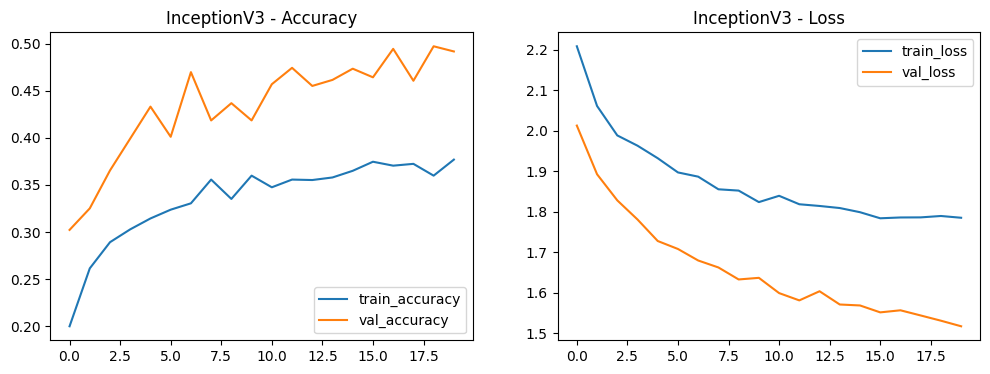

In [16]:
results = {}

for model_name, (model_func, preprocess) in models_to_train.items():
    print(f"\nTraining {model_name}...")
    model = build_transfer_model(model_func, preprocess, model_name)
    history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS, callbacks=[early_stop])
    model.save(f"models/{model_name}.h5")
    plot_history(history, model_name)
    results[model_name] = model

#### Helper Function for Evaluating all Transfer Models

In [17]:
def evaluate_model(model, model_name):
    predictions = model.predict(test_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_data.classes

    print(f"\n{model_name} - Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"plots/{model_name}_confusion_matrix.png")
    plt.show()



#### Evaluating All Models

2025-08-09 15:44:27.056633: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.6 = (f32[32,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0} %bitcast.187, f32[32,3,3,3]{3,2,1,0} %bitcast.194, f32[32]{0} %bitcast.196), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/tanuj/myenv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-08-09 15:44:27.178172: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algo

 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step

2025-08-09 15:44:45.018652: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.6 = (f32[19,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,3,224,224]{3,2,1,0} %bitcast.187, f32[32,3,3,3]{3,2,1,0} %bitcast.194, f32[32]{0} %bitcast.196), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/tanuj/myenv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-08-09 15:44:45.172945: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algo

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step

Custom_CNN - Classification Report:

                                  precision    recall  f1-score   support

                     animal fish       0.20      0.42      0.27       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.11      0.76      0.19       292

                        accu

/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


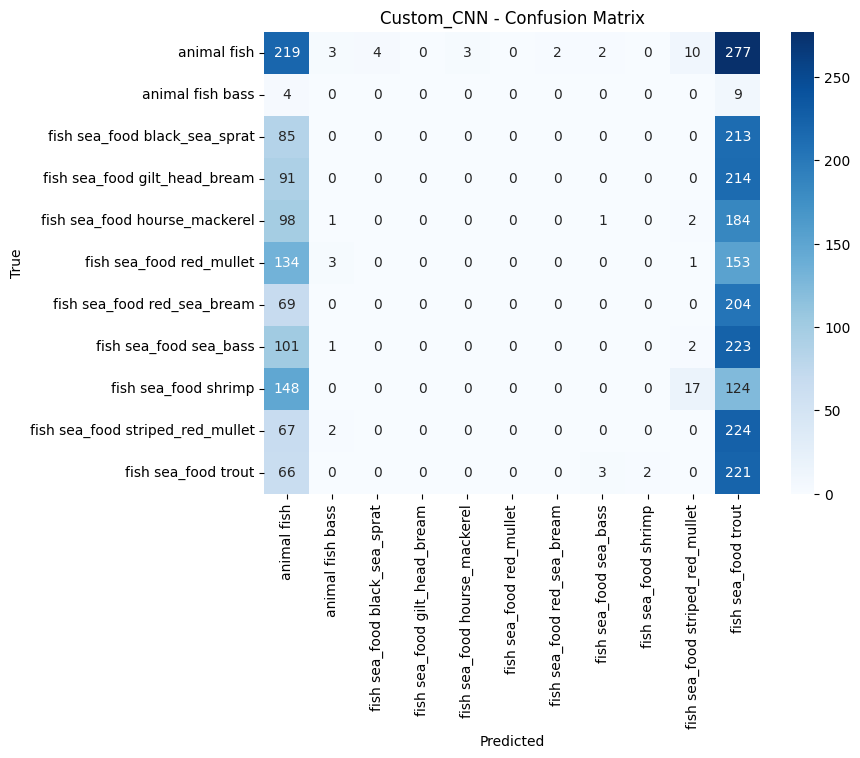

 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step

2025-08-09 15:45:10.433012: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[19,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,3,224,224]{3,2,1,0} %bitcast.505, f32[64,3,3,3]{3,2,1,0} %bitcast.512, f32[64]{0} %bitcast.514), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/tanuj/myenv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-08-09 15:45:10.628175: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] O

100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 310ms/step

VGG16 - Classification Report:

                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00      0.00       292

                        accuracy 

/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


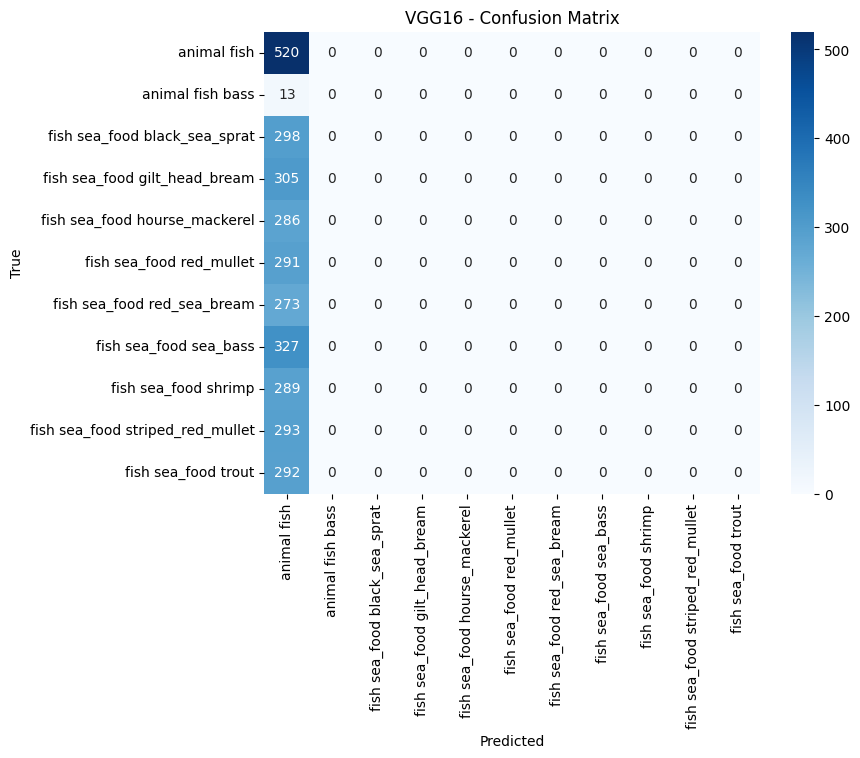

 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step

2025-08-09 15:45:41.874604: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.162 = (f32[19,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,64,56,56]{3,2,1,0} %bitcast.4528, f32[64,64,3,3]{3,2,1,0} %bitcast.4535, f32[64]{0} %bitcast.4537), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/resnet50_1/conv2_block1_2_conv_1/convolution" source_file="/home/tanuj/myenv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-08-09 15:45:42.368006: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 214ms/step

ResNet50 - Classification Report:

                                  precision    recall  f1-score   support

                     animal fish       0.26      0.82      0.39       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.57      0.24      0.34       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.33      0.64      0.43       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.29      0.28      0.29       273
          fish sea_food sea_bass       0.43      0.24      0.30       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.37      0.34      0.36       293
             fish sea_food trout       0.28      0.14      0.19       292

                        accura

/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


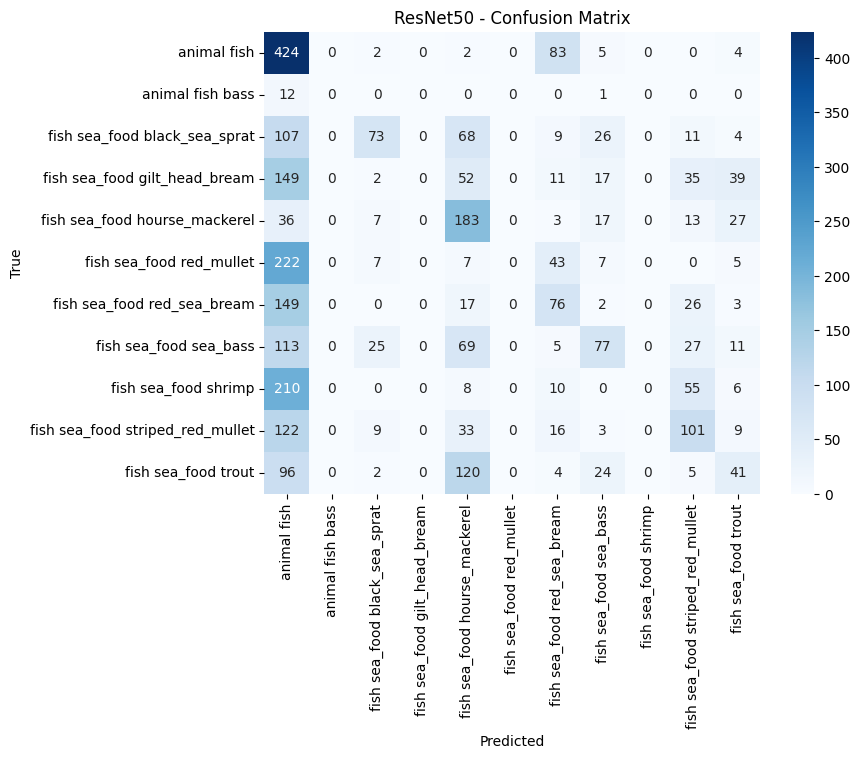

100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 208ms/step

MobileNetV2 - Classification Report:

                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00      0.00       292

                        acc

/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


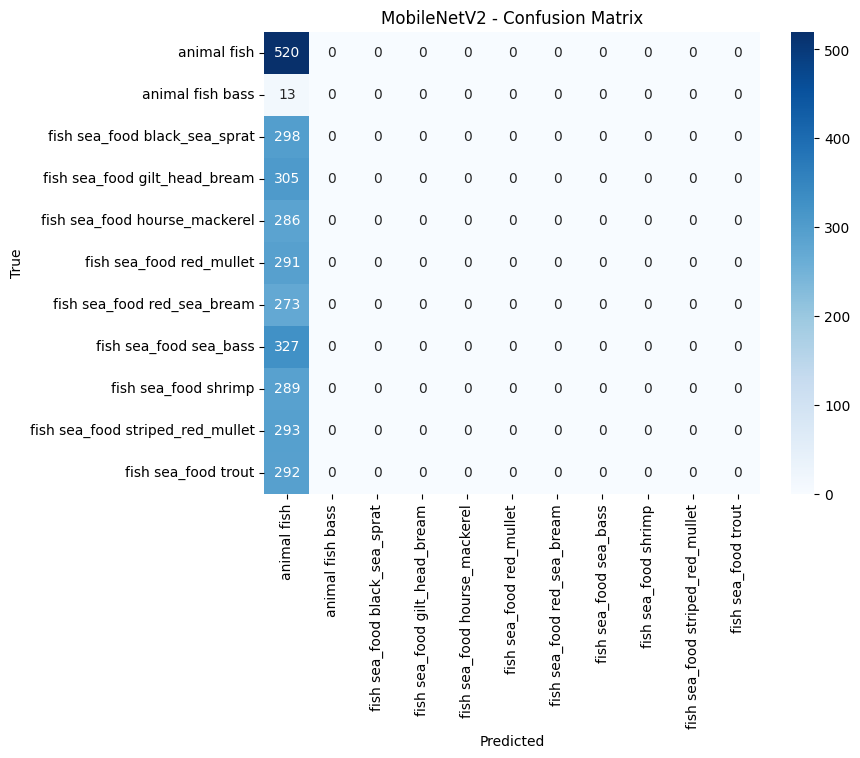

100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 239ms/step

InceptionV3 - Classification Report:

                                  precision    recall  f1-score   support

                     animal fish       0.60      0.87      0.71       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.57      0.56      0.57       298
   fish sea_food gilt_head_bream       0.44      0.20      0.27       305
   fish sea_food hourse_mackerel       0.50      0.61      0.55       286
        fish sea_food red_mullet       0.38      0.24      0.30       291
     fish sea_food red_sea_bream       0.42      0.47      0.45       273
          fish sea_food sea_bass       0.56      0.33      0.42       327
            fish sea_food shrimp       0.38      0.75      0.50       289
fish sea_food striped_red_mullet       0.55      0.23      0.32       293
             fish sea_food trout       0.55      0.54      0.54       292

                        acc

/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tanuj/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


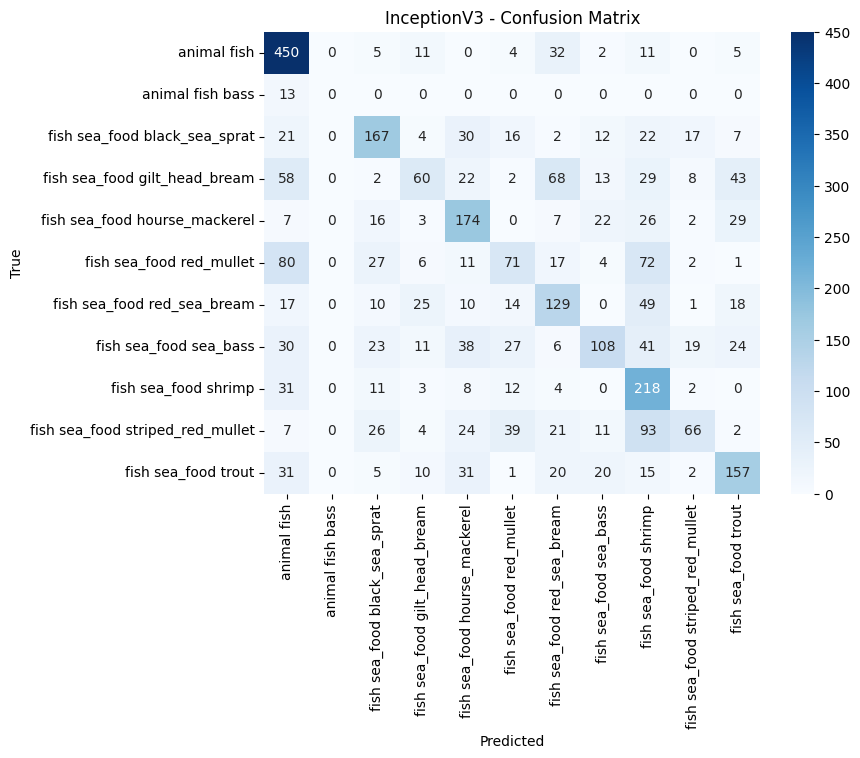

In [18]:
# Evaluate all models
evaluate_model(cnn_model, "Custom_CNN")
for model_name, model in results.items():
    evaluate_model(model, model_name)
